In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import re
import preprocessor as p


In [2]:
#chunksize = 10 ** 8

btcdata = pd.read_csv('../data/interim/bitcoin_engage_tweets_test.csv')
#btcdata = pd.read_csv('../data/raw/btc-tweets-2016-2019/tweets.csv', sep='delimiter', header=None, low_memory=False)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,4,5,6,8,9,10,11,12,17,21,22,23,27,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
btcdata.shape



btcdata = btcdata[['id', 'date', 'text', 'hashtags', 'replyCount', 'retweetCount',
'likeCount', 'userName', 'userFollowerCount', 'userFavCount', 'userFriendCount']]

btcdata.head()
btcdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884180 entries, 0 to 1884179
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   id                 object
 1   date               object
 2   text               object
 3   hashtags           object
 4   replyCount         object
 5   retweetCount       object
 6   likeCount          object
 7   userName           object
 8   userFollowerCount  object
 9   userFavCount       object
 10  userFriendCount    object
dtypes: object(11)
memory usage: 158.1+ MB


In [4]:
#btcdata = btcdata[["user_followers", "user_friends", "user_favourites","text"]]
btcdata.shape

btcdata = btcdata[(btcdata["userFollowerCount"].notna()) & (btcdata["userFavCount"].notna()) & (btcdata["userFriendCount"].notna())]

#btcdata = btcdata[btcdata["user_friends"] != "False"]


btcdata['replyCount'] = pd.to_numeric(btcdata['replyCount'], errors='coerce')
btcdata['retweetCount'] = pd.to_numeric(btcdata['retweetCount'], errors='coerce')
btcdata['likeCount'] = pd.to_numeric(btcdata['likeCount'], errors='coerce')
btcdata['userFollowerCount'] = pd.to_numeric(btcdata['userFollowerCount'], errors='coerce')
btcdata['userFavCount'] = pd.to_numeric(btcdata['userFavCount'], errors='coerce')
btcdata['userFriendCount'] = pd.to_numeric(btcdata['userFriendCount'], errors='coerce')



#btcdata.shape
btcdata = btcdata.dropna(subset=['replyCount', 'retweetCount', 'likeCount', 'userFollowerCount', 'userFavCount', 'userFriendCount'])
#btcdata.query("(user_followers == 0) & (user_friends == 0) & (user_favourites == 0)").describe()
btcdata.shape
#btcdata = btcdata.astype({
    #"userFollowerCount": "int",
    #"userFavCount": "int",
    #"userFriendCount": "int",
    #"replyCount": "int",
    #"retweetCount": "int",
    #"likeCount": "int"
    #}) 


#btcdata.describe().apply(lambda s: s.apply('{0:.5f}'.format))



(1884177, 11)

In [5]:
#converting to datetime from string
btcdata["dateTime"] = pd.to_datetime(btcdata["date"], format="%Y-%m-%d %H:%M:%S", errors='coerce')

#to get rows from a period of time using dateTime
#august = btcdata[(btcdata['dateTime'] > '2021-08-01') & (btcdata['dateTime'] < '2021-09-01')]


In [6]:
btcdata.text[30000:40000]
#data = btcdata.astype({"text": "str"}, copy=True)
#data['text'] = data['text'].str.replace('@[\w]+', '')
#data.info()


30000    @Slytoshi @RebelRabbits1 @REBEL_JQKER LEGEND @...
30001    [SCAN RESULTS - 4h]\n\nExchange: #KuCoin\n\nTo...
30002    @nokie555 @fredtheinvestor @ThobelaniMchun3 Th...
30003                              @crypto_birb $BTC Green
30004    #DecentralizedFinance is  buzz word of late. T...
                               ...                        
39995                            Amazing reaction Congrats
39996    I can see that being the bottom tbh. Good amou...
39997    Might start shilling SOL NFTs in Bitcoin Maxi ...
39998    @TimFindlay @jacobcabe Trust me, I don't trust...
39999    📄 Transaction Report\n🖥 GMO Coin\n🕘 2021-09-30...
Name: text, Length: 10000, dtype: object

In [7]:
btcdata['text'] = btcdata['text'].apply(lambda x: x.lower()) #transform text to lowercase


data = btcdata
data.text[39999]

'📄 transaction report\n🖥 gmo coin\n🕘 2021-09-30 09:45 jst\n📖 open buy 0.11 btc/jpy\n#⃣ #bitcoin #ビットコイン #自動売買'

In [8]:
#dropping the tweets from users with no followers, friends and favourites
print('before dropping invalid users:' , data.shape)
data = data[~((data["userFollowerCount"] == 0) & (data["userFavCount"] == 0) & (data["userFriendCount"] == 0))]
#data = data.drop(data[(data["user_followers"] == 0) | (data["user_friends"] == 0) | (data["user_favourites"] == 0)].index)
print('after dropping invalid users:', data.shape)


before dropping invalid users: (1884177, 12)
after dropping invalid users: (1883978, 12)


In [9]:
#dropping the tweets with suspicious hashtags, words, bigrams, and trigrams

#any(substring in string for substring in substring_list)

#hashtags
print('before dropping by hashtags:' , data.shape)
data = data[~data.text.str.contains('#freecrypto|#freemoney|#freebitcoin|#freebtc')]
print('after dropping by hashtags:' , data.shape)

#words
print('before dropping by single keyword:' , data.shape)
data = data[~data.text.str.contains('entertaining|subscribe')]
print('after dropping by single keyword:' , data.shape)

#bigrams
print('before dropping by bigrams:' , data.shape)
data = data[~(data.text.str.contains('free bitcoin|current price|bitcoin price|earn bitcoin'))]
print('after dropping by bigrams:' , data.shape)
#data = data[~(data.text.str.contains('current') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('bitcoin') & (data.text.str.contains('price')))]
#data = data[~(data.text.str.contains('earn') & (data.text.str.contains('bitcoin')))]

#trigrams
print('before dropping by trigrams:' , data.shape)
data = data[~(data.text.str.contains('start trading bitcoin'))]
print('after dropping by trigrams:' , data.shape)


before dropping by hashtags: (1883978, 12)
after dropping by hashtags: (1883139, 12)
before dropping by single keyword: (1883139, 12)
after dropping by single keyword: (1879863, 12)
before dropping by bigrams: (1879863, 12)
after dropping by bigrams: (1860778, 12)
before dropping by trigrams: (1860778, 12)
after dropping by trigrams: (1860741, 12)


In [10]:
#Remove urls, mentions, hashtags, empty lines, spaces, reserved words (RT, FAV)
#keep emojis, smileys, numbers

data.text[39999]

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED)
data['text'] = data['text'].apply(lambda x: p.clean(x))



In [11]:
#Check the header of formated text
data.text[100:200]


101    you know it right? you don't have to buy an en...
102    the nuclear power industry screws up constantl...
103                                the answer is bitcoin
104                               my goodness the vols 🤯
105                                  love your neighbor.
                             ...                        
199    i thought lightning was its own network for li...
200    amazed with and swapped ltc to btc in under 3 ...
201    i only feel this way when bitcoin goes down. w...
202    is going to be everywhere 👀 with all the huge ...
203    self-serving. self-serving .... self-serving ....
Name: text, Length: 100, dtype: object

In [12]:
#remove special characters
#data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x)) 

In [13]:
#remove extra space between words
#data['text'] = data['text'].apply(lambda x: re.sub(' +', ' ', x)) 

In [14]:
#save the length of each tweets to df
data['textLength'] = data['text'].str.len()

Display histograms of tweets length

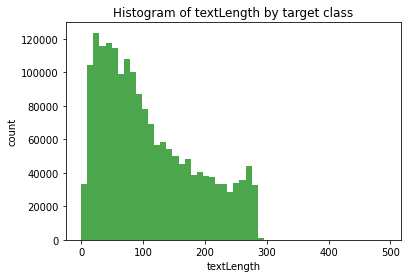

In [15]:
#display histograms of tweets length
#cols = ["user_followers", "user_friends", "user_favourites"]

#for col in cols:
col = "textLength"
#btcdata = btcdata.astype({"user_friends": "float64"}) #Conv datatype of df3, user_followers Col from object to int64
#pos_series = btcdata[col].tolist()
#neg_series = negative_examples[col].tolist()
plt.hist(data[col], 50, facecolor='g', alpha=0.7)
#plt.hist(neg_series, 50, facecolor='r', alpha=0.7, label="0")
#plt.legend(prop={"size": 10})
plt.xlabel(col)
plt.ylabel("count")
plt.ticklabel_format(style='plain')
plt.title("Histogram of " + col + " by target class")
plt.show()

Check the total number of tweets for each day, overlay with bitcoin closing price

In [16]:
#load bitcoin pricing information
price = pd.read_csv('../data/external/BTC_USD_2020-10-10_2021-10-09-CoinDesk.csv')
pdata = price[['Date', 'Closing Price (USD)']]

In [17]:
#count number of tweets each date
df = data['dateTime'].groupby(data['dateTime'].dt.date).size().reset_index(name='count')

In [29]:
#merge two dfs by date


df = df.astype({"dateTime": "str"}) 
print(type(df['dateTime'][0]))
print(type(pdata['Date'][0]))

merged_df1 = pd.merge(left=df, right=pdata, left_on='dateTime', right_on='Date')
merged_df1 = merged_df1.astype({"Closing Price (USD)": "int"}) 
merged_df1

<class 'str'>
<class 'str'>


,dateTime,count,Date,Closing Price (USD)
0,2021-07-22,11987,2021-07-22,32203
1,2021-07-23,22651,2021-07-23,33117
2,2021-07-24,21151,2021-07-24,34014
3,2021-07-25,21230,2021-07-25,34574
4,2021-07-26,42477,2021-07-26,37114
...,...,...,...,...
66,2021-09-26,24423,2021-09-26,43572
67,2021-09-27,35703,2021-09-27,43136
68,2021-09-28,34524,2021-09-28,41734
69,2021-09-29,41330,2021-09-29,41412


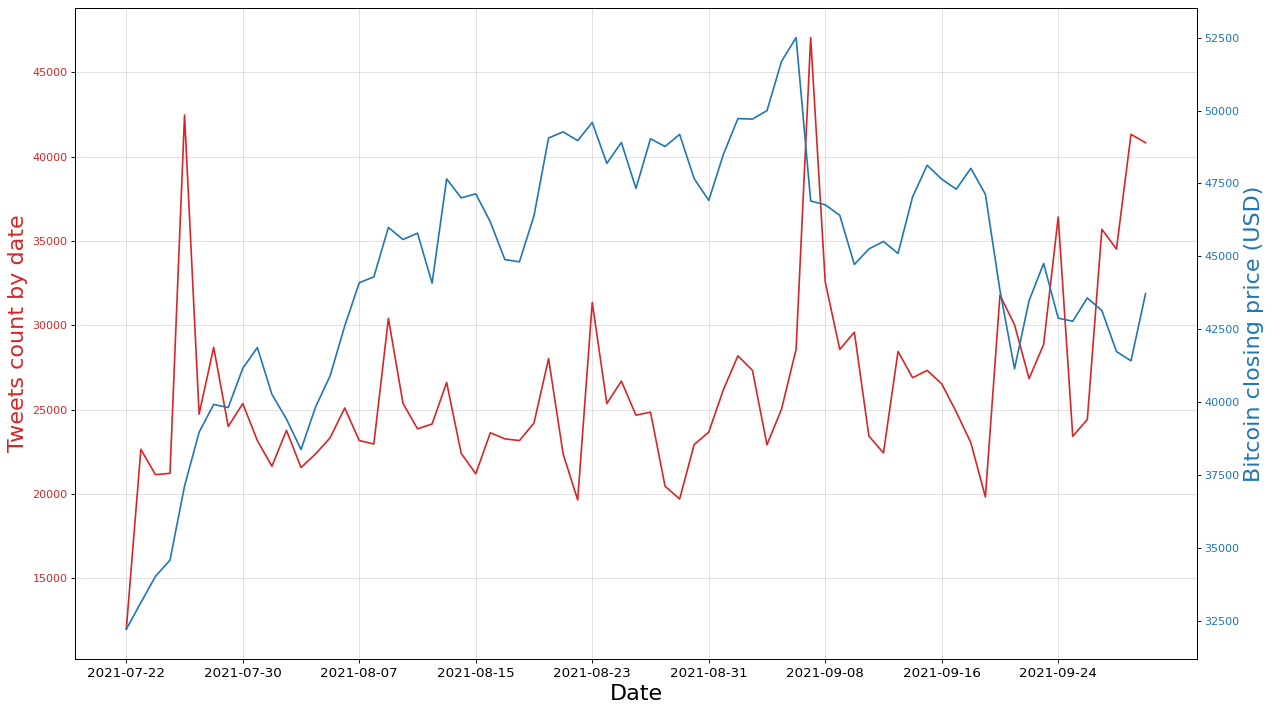

In [38]:
x = merged_df1['dateTime']
y1 = merged_df1['count']
y2 = merged_df1['Closing Price (USD)']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')


# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Date', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Tweets count by date', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Bitcoin closing price (USD)", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 8))
ax2.set_xticklabels(x[::8], rotation=90, fontdict={'fontsize':10})
#ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)

fig.tight_layout()
plt.show()




Randomly select rows from each day

In [29]:
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x :x.iloc[random.choice(range(0,len(x)))])
#btcdata.groupby(btcdata['date_time'].dt.year).apply(lambda x: x.sample(2)).reset_index(drop=True)

selected = data.groupby(data['dateTime'].dt.day).apply(lambda x: x.sample(10, random_state=889))

selected.to_csv('sample_bitcoin_tweets_ten_each_day.csv')
selected

id                       date  \
dateTime                                                           
1        877320   1432982797438889985  2021-09-01 08:24:57+00:00   
         1620664  1421887791797919744  2021-08-01 17:37:21+00:00   
         863024   1433146446728024065  2021-09-01 19:15:14+00:00   
         872346   1433054222388396055  2021-09-01 13:08:46+00:00   
         877074   1432987140791672835  2021-09-01 08:42:12+00:00   
...                               ...                        ...   
31       1652708  1421357858134822913  2021-07-31 06:31:35+00:00   
         1655000  1421310741588496386  2021-07-31 03:24:22+00:00   
         898887   1432663044157489159  2021-08-31 11:14:21+00:00   
         1654542  1421318263133310983  2021-07-31 03:54:15+00:00   
         886224   1432819299429888005  2021-08-31 21:35:16+00:00   

                                                               text  \
dateTime                                                              
1        877320   keep putting money into your pension, everythi...   
         1620664  the divine line “bitcoin/cryptocurrency is for...   
         863024                                          shop &amp;   
         872346              gm fam. breaking $50k today. 👊 send it   
         877074   delegates from el salvador's finance commissio...   
...                                                             ...   
31       1652708  imagine if everyone in bitcoin and the larger ...   
         1655000                             full send!!! 💚🚀💥👻🔥✈️✈️   
         898887   $eth flips $btc on its next run up and i don’t...   
         1654542  join me at bitcoin: macroeconomics, geopolitic...   
         886224   when you say "a bitcoin model" you mean they u...   

                                                           hashtags  \
dateTime                                                              
1        877320                          ['Bitcoin', 'FoxBusiness']   
         1620664  ['crypto', 'btc', 'bitcoin', 'bnb', 'bsc', 'cr...   
         863024   ['linkedin', 'twitter', 'facebook', 'instagram...   
         872346                                         ['bitcoin']   
         877074                           ['Bitcoin', 'ElSalvador']   
...                                                             ...   
31       1652708                                                NaN   
         1655000                                                NaN   
         898887                                                 NaN   
         1654542                                                NaN   
         886224                                                 NaN   

                  replyCount  retweetCount  likeCount         userName  \
dateTime                                                                 
1        877320          0.0           0.0        1.0  Alberto62316949   
         1620664         0.0           0.0        1.0     Bbcryptonews   
         863024          0.0           1.0        0.0  bmurphypointman   
         872346         12.0           6.0      127.0       kailybuemi   
         877074          0.0           0.0        2.0  CryptoManiacs10   
...                      ...           ...        ...              ...   
31       1652708         5.0           2.0       36.0         austorms   
         1655000         0.0           0.0        1.0  WatchingCryptYo   
         898887          0.0           5.0       26.0         notEezzy   
         1654542         0.0           0.0        1.0     Bitcoindad88   
         886224          0.0           0.0       10.0          GSR6669   

                  userFollowerCount  userFavCount  userFriendCount  \
dateTime                                                             
1        877320                55.0         819.0            225.0   
         1620664              563.0         422.0           1357.0   
         863024             71127.0          24.0          